In [1]:
#Import Modules
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq
import scipy.stats as stats
from matplotlib import colors
from matplotlib.gridspec import GridSpec

In [2]:
def Read_File(file_path, dedisperse = True):
    File = psrchive.Archive_load(file_path)
    File.tscrunch()
    if dedisperse == True:
        File.dedisperse()
    File.pscrunch()
    File.remove_baseline()
    dm = File.get_dispersion_measure()
    center_freq = File.get_centre_frequency()
    integration = File.get_first_Integration()
    period = integration.get_folding_period()
    File_Data = File.get_data()
    pulse = File_Data[0,0,:] #Select usable part of data
    
    #Get a list of the frequencies
    freq_mhz_table = File.get_frequency_table()
    freq_mhz = freq_mhz_table[0]
    
    
    return(pulse, freq_mhz, dm, center_freq, period)

In [3]:
def Select_Off_Pulse(File_Data, On_Pulse_Start, On_Pulse_Stop):
    #Length of freq_pulse
    len_arr = len(File_Data)
    #Create a range of zeros for the data that is removed.
    len_on_pulse = On_Pulse_Stop - On_Pulse_Start
    buckets = [np.nan] * len_on_pulse
    #Select only off-pulse channels
    off_pulse = []
    for i in range(0,len_arr):
        off_pulse.append(np.concatenate((File_Data[i][:On_Pulse_Start], buckets, File_Data[i][On_Pulse_Stop:])))
    return(off_pulse)

In [4]:
def root_mean_squared(Data):
    rms_value = np.sqrt(np.nanmean(Data**2))
    return(rms_value)

In [5]:
def Calculate_Stats(Data):
    #Create lists
    median_arr = []
    mean_arr = []
    std_arr = []
    sum_arr = []
    kurtosis_arr = []
    
    #Calculate the length of the array:
    array_length = len(Data)
    
    for i in range(0,array_length):
        #Calculate median
        median_arr.append(np.nanmedian(Data[i]))
        #Calculate mean for every channel
        mean_arr.append(np.nanmean(Data[i]))
        #Calculate standard deviation for every channel
        std_arr.append(np.nanstd(Data[i]))
        #Calculate sum for every channel
        sum_arr.append(np.nansum(Data[i]))
        #Calculate kurtosis for every channel
        kurtosis_arr.append(stats.kurtosis(Data[i], nan_policy='omit'))
    return(median_arr, mean_arr, std_arr, sum_arr, kurtosis_arr)

In [6]:
def Calculate_4Stats(Data):
    median_arr = []
    std_arr = []
    kurtosis_arr = []
    skew_arr = []
    
    #Calculate the length of the array:
    array_length = len(Data)
        
    for i in range(0,array_length):
        #Calculate median
        median_arr.append(np.nanmedian(Data[i]))
        #Calculate std
        std_arr.append(np.nanstd(Data[i]))
        #Calculate kurtosis for every channel
        kurtosis_arr.append(stats.kurtosis(Data[i], nan_policy='omit'))
        #Calculate Skew for every channel
        skew_arr.append(stats.skew(Data[i], nan_policy='omit'))
    
    kurtosis_arr = np.where(kurtosis_arr=='masked', np.nan, kurtosis_arr)
    skew_arr = np.where(kurtosis_arr=='masked', np.nan, skew_arr)
    
    return(median_arr, std_arr, kurtosis_arr, skew_arr)

In [7]:
def Convert_To_Matrix(median_bin, mean, std_bin, sum_bin, kurtosis_bin):  
    #Create a matrix for the median
    median_matrix = []
    median_matrix.append(median_bin)
    
    #Create a matrix for the mean
    mean_matrix = []
    mean_matrix.append(mean_bin)
    
    #Create a matrix for the standard deviation
    std_matrix = []
    std_matrix.append(std_bin)
    
    #Create a matrix for the sum
    sum_matrix = []
    sum_matrix.append(sum_bin)
    
    #Create a matrix for the kurtosis
    kurtosis_matrix = []
    kurtosis_matrix.append(kurtosis_bin)
    return(median_bin, mean, std_bin, sum_bin, kurtosis_bin)

In [8]:
def Freq_Plotting_All(freq_mhz, median_arr, mean_arr, std_arr, sum_arr, kurtosis_arr, plot_title):
    fig, axes = plt.subplots(5,figsize=(32,18))
    axes[0].bar(freq_mhz, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median Intensity')
    axes[1].bar(freq_mhz, mean_arr)
    axes[1].set_ylabel('Mean Intensity')
    axes[2].bar(freq_mhz, std_arr)
    axes[2].set_ylabel('Standard Deviation of Intensity')
    axes[3].bar(freq_mhz, sum_arr)
    axes[3].set_ylabel('Sum of Intensity')
    axes[4].bar(freq_mhz, kurtosis_arr)
    axes[4].set_ylabel('Kurtosis of Intensity')
    axes[4].set_xlabel('Frequency [MHz]')
    plt.show()
    plt.close()

In [9]:
def Freq_Plotting_3(freq_mhz, median_arr, kurtosis_arr, skew_arr, plot_title):
    fig, axes = plt.subplots(3,figsize=(32,18))
    axes[0].bar(freq_mhz, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median of Intensity')
    axes[1].bar(freq_mhz, kurtosis_arr)
    axes[1].set_ylabel('Kurtosis of Intensity')
    axes[2].bar(freq_mhz, skew_arr)
    axes[2].set_ylabel('Skew of Intensity')
    axes[2].set_xlabel('Frequency [MHz]')
    plt.show()
    plt.close()

In [10]:
def Bin_Plotting_3(bins, median_arr, kurtosis_arr, skew_arr, plot_title):
    fig, axes = plt.subplots(3,figsize=(32,18))
    axes[0].bar(bins, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median of Intensity')
    axes[1].bar(bins, kurtosis_arr)
    axes[1].set_ylabel('Kurtosis of Intensity')
    axes[2].bar(bins, skew_arr)
    axes[2].set_ylabel('Skew of Intensity')
    axes[2].set_xlabel('Pulse Phase [Bins]')
    plt.show()
    plt.close()

In [11]:
def convert_list_to_int(lst):
    int_list = []
    for item in lst:
        try:
            int_value = int(item)
            int_list.append(int_value)
        except ValueError:
            print(f"Warning: Could not convert '{item}' to an integer.")
    return int_list

In [12]:
def import_list_from_txt(filename):
    result = []
    with open(filename, 'r') as file:
        for line in file:
            item = line.strip()  # Remove leading/trailing whitespace and newline characters
            result.append(item)
    return result

In [13]:
def replace_values_with_nan(values_list, indexes_to_replace):
    new_list = values_list.copy()  # Create a copy of the original list
    for index in indexes_to_replace:
        if 0 <= index < len(new_list):
            new_list[index] = np.nan
        else:
            print(f"Warning: Index {index} is out of range.")
    return new_list

In [14]:
def Zap_Bad_Freqs(data, bad_chn_list, read_file):
    if read_file == True:
        bad_chns_str = import_list_from_txt(bad_chn_list)
        bad_chns = convert_list_to_int(bad_chns_str)
    if read_file == False:
        bad_chns = bad_chn_list
    
    chn = replace_values_with_nan(data, bad_chns)
    return(chn)

In [15]:
def calculate_rms_with_peak_removal(your_list, threshold_multiplier=2, peak_distance=2):
    # Convert your_list to a NumPy array for calculations
    your_array = np.array(your_list)

    # Calculate RMS of the entire array
    rms = np.sqrt(np.nanmean(your_array**2))

    # Set peak threshold to a multiple of RMS
    peak_threshold = threshold_multiplier * rms

    # Find peaks in the array
    peaks, _ = find_peaks(your_array, height=peak_threshold, distance=peak_distance)

    # Set peak values to nan in the modified array
    modified_array = np.copy(your_array)
    modified_array[peaks] = np.nan

    # Calculate RMS for the entire modified array
    new_rms = np.sqrt(np.nanmean(modified_array**2))

    return modified_array, new_rms

In [16]:
def cleanRFI_Narrowband(data, std_cutoff):
    #rms_data = root_mean_squared(data)
    bad_chns = []
    median, std, kurtosis, skew = Calculate_4Stats(data)
    
    median_arr = np.array(median)
    std_arr = np.array(std)
    kurtosis_arr = np.array(kurtosis)
    skew_arr = np.array(skew)
    
    rms_median = root_mean_squared(median_arr)
    rms_std = root_mean_squared(std_arr)
    
    std_median = np.nanstd(median)
    std_kurtosis = np.nanstd(kurtosis_arr)
    std_skew = np.nanstd(skew_arr)
    
    #print('STD Median: ' + str(std_median))
    #print('STD Kurtosis: ' + str(std_kurtosis))
    #print('STD Skew: ' + str(std_skew))
    
    #Calculate the length of the array:
    array_length = len(data)
    
    #median_rms_arr, median_rms = calculate_rms_with_peak_removal(median_arr)
    #std_rms_arr, std_rms = calculate_rms_with_peak_removal(std_arr)
    #kurtosis_rms_arr, kurtosis_rms = calculate_rms_with_peak_removal(kurtosis_arr)
    #skew_rms_arr, skew_rms = calculate_rms_with_peak_removal(skew_arr)
    
    #Clean the data based on a hard cutoff to the statistics + rms baseline for mean and std
    for i in range(0,array_length):
        median = np.nanmedian(data[i])
        kurtosis = stats.kurtosis(data[i], nan_policy='omit')
        skew = stats.skew(data[i], nan_policy='omit')
        std = np.nanstd(data[i]) 
        if (median > (std_cutoff + rms_median)) or (median < (-std_cutoff + rms_median)) \
        or (std > (std_cutoff + rms_std)) or (std < (-std_cutoff + rms_std)) \
        or (kurtosis > (std_cutoff)) or (kurtosis < (-std_cutoff)) \
        or (skew >(std_cutoff)) or skew < (- std_cutoff):
                bad_chns.append(i)    
    
    #Clean the data based only on the kurtosis
    #for i in range(0,len(kurtosis_arr)):
    #    if (kurtosis_arr[i] > (std_cutoff)) or (kurtosis_arr[i] < (-std_cutoff)):
    #        bad_chns.append(i)    
    
    #Used to clean data based on the std of the statistic array
    #for i in range(0,array_length):
    #    median = np.nanmedian(data[i])
    #    kurtosis = stats.kurtosis(data[i], nan_policy='omit')
    #    skew = stats.skew(data[i], nan_policy='omit')
    #    std = np.nanstd(data[i]) 
    #    if (median > (std_cutoff*std_median)) or (median < (- std_cutoff*std_median)) \
    #    or (kurtosis > (std_cutoff*std_kurtosis)) or (kurtosis < (-std_cutoff*std_kurtosis)) \
    #    or (skew >(std_cutoff*std_skew)) or skew < (- std_cutoff*std_skew)\
    #    or (std > std_cutoff) or (std < - std_cutoff):
    #            bad_chns.append(i)
    
    chn = replace_values_with_nan(data, bad_chns)
    #print('cleanRFI: ' + str(np.shape(chn)))
    return(chn)

In [17]:
def cleanRFI_Wideband(data, std_cutoff):
    bad_chns = []
    median, std, kurtosis, skew = Calculate_4Stats(data)
    
    median_arr = np.array(median)
    std_arr = np.array(std)
    kurtosis_arr = np.array(kurtosis)
    skew_arr = np.array(skew)
    
    rms_median = root_mean_squared(median_arr)
    rms_std = root_mean_squared(std_arr)
    
    std_median = np.nanstd(median)
    std_kurtosis = np.nanstd(kurtosis_arr)
    std_skew = np.nanstd(skew_arr)
    
    #Calculate the length of the array:
    array_length = len(data)
    
    #Clean the data based on a hard cutoff to the statistics + rms baseline for mean and std
    for i in range(0,array_length):
        median = np.nanmedian(data[i])
        kurtosis = stats.kurtosis(data[i], nan_policy='omit')
        skew = stats.skew(data[i], nan_policy='omit')
        std = np.nanstd(data[i]) 
        if (median > (std_cutoff + rms_median)) or (median < (-std_cutoff + rms_median)) or (median < -0.01) \
        or (std > (std_cutoff + rms_std)) or (std < (-std_cutoff + rms_std)) \
        or (kurtosis > (std_cutoff)) or (kurtosis < (-std_cutoff)) \
        or (skew >(std_cutoff)) or skew < (- std_cutoff):
                bad_chns.append(i)    
    
    chn = replace_values_with_nan(data, bad_chns)
    #print('cleanRFI: ' + str(np.shape(chn)))
    return(chn)

In [18]:
def plot_stat_histograms(median_arr, std_arr, kurtosis_arr, skew_arr):
    plt.hist(median_arr)
    plt.title('median')
    plt.xlabel('median value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    # We can test how close it is to a normal distribution
    #The null hypothesis of this test is that the data follows a normal distribution.
    #If the statistic is low then this is evidence of departure from normality.
    #If the p-value is lower than the threshold (ex: 0.05), then we reject the null 
    #hypothesis and conclude that the data does not follow a normal distribution.
    #median_arr_flat = np.ravel(median_arr)
    #median_arr_without_nan = median_arr_flat[~np.isnan(median_arr_flat)]#First we need to remove the nan values
    
    #Flatten the array
    median_arr_flat = np.ravel(median_arr)
    median_arr_without_nan = median_arr_flat[~np.isnan(median_arr_flat)]
    
    median_stat, median_pvalue = stats.shapiro(median_arr_without_nan)
    print('Median W-Statistic: ' + str(median_stat))
    print('Median P-Value: ' + str(median_pvalue))
    
    plt.hist(std_arr)
    plt.title('std')
    plt.xlabel('std value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    std_arr_flat = np.ravel(std_arr)
    std_arr_without_nan = std_arr_flat[~np.isnan(std_arr_flat)]
    
    std_stat, std_pvalue = stats.shapiro(std_arr_without_nan)
    print('STD W-Statistic: ' + str(std_stat))
    print('STD P-Value: ' + str(std_pvalue))
    
    plt.hist(kurtosis_arr)
    plt.title('kurtosis')
    plt.xlabel('kurtosis value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    kurtosis_arr_flat = np.ravel(kurtosis_arr)
    kurtosis_arr_without_nan = kurtosis_arr_flat[~np.isnan(kurtosis_arr_flat)]
    
    kurtosis_stat, kurtosis_pvalue = stats.shapiro(kurtosis_arr_without_nan)
    print('Kurtosis W-Statistic: ' + str(kurtosis_stat))
    print('Kurtosis P-Value: ' + str(kurtosis_pvalue))

    plt.hist(skew_arr)
    plt.title('skew')
    plt.xlabel('skew value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    skew_arr_flat = np.ravel(skew_arr)
    skew_arr_without_nan = skew_arr_flat[~np.isnan(skew_arr_flat)]    
    
    skew_stat, skew_pvalue = stats.shapiro(skew_arr_without_nan)
    print('Skew W-Statistic: ' + str(skew_stat))
    print('Skew P-Value: ' + str(skew_pvalue))

In [19]:
def plot_full_histogram(off_pulse):
    #Flatten the array
    off_pulse_flat = np.ravel(off_pulse)
    off_pulse_without_nan = off_pulse_flat[~np.isnan(off_pulse_flat)]
    
    plt.hist(off_pulse_without_nan, bins =50)
    plt.title('Off Pulse Distribution')
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    # We can test how close it is to a normal distribution
    #The null hypothesis of this test is that the data follows a normal distribution.
    #If the statistic is low then this is evidence of departure from normality.
    #If the p-value is lower than the threshold (ex: 0.05), then we reject the null 
    #hypothesis and conclude that the data does not follow a normal distribution.   
    off_pulse_stat, off_pulse_pvalue = stats.shapiro(off_pulse_without_nan)
    print('Off-Pulse W-Statistic: ' + str(off_pulse_stat))
    print('Off-Pulse P-Value: ' + str(off_pulse_pvalue))

In [20]:
def nan_list(my_list):
    indices_of_nan = [index for index, value in enumerate(my_list) if isinstance(value, (float, np.floating)) and np.isnan(value)]
    return indices_of_nan

In [21]:
def set_sublists_to_nan(main_list, index_list):
    for index in index_list:
        if index < len(main_list):
            main_list[index] = [np.nan] * len(main_list[index])
    
    return main_list

In [22]:
def plot_statistics(data, freq_mhz, numsubint, freq_domain_median, freq_domain_std, freq_domain_kurtosis, \
                    freq_domain_skew, time_domain_median, time_domain_std, \
                    time_domain_kurtosis, time_domain_skew, RFI_removed, SNR, plot_title_dedisp, plot_title_disp):
    
    #Disperse the data to create the dispersed data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    time_res = period/numsubint #Period/number of bins
    data_disp = disperse(data, dm, center_freq, freq_mhz, time_res)
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    gs = GridSpec(nrows=10, ncols=15)

    ax0 = plt.subplot(gs[0:4,0])
    ax0.set_xlabel('Median')
    ax0.set_ylabel('Frequency [MHz]')
    flipped_y = np.flip(freq_mhz)
    ax0.plot(
        freq_domain_median,
        flipped_y,
        color='black'
    )
    ax0.set_ylim(np.min(freq_mhz), np.max(freq_mhz))

    ax1 = plt.subplot(gs[0:4,1])
    ax1.set_xlabel('STD')
    ax1.plot(
        freq_domain_std,
        range(0, len(freq_domain_std)),
        color='black'
    )
    ax1.set_ylim(0, len(freq_domain_std))

    ax2 = plt.subplot(gs[0:4,2])
    ax2.set_xlabel('Kurtosis')
    ax2.plot(
        freq_domain_kurtosis,
        range(0, len(freq_domain_kurtosis)),
        color='black'
    )
    ax2.set_ylim(0, len(freq_domain_kurtosis))

    ax3 = plt.subplot(gs[0:4,3])
    ax3.set_xlabel('Skew')
    ax3.plot(
        freq_domain_skew,
        range(0, len(freq_domain_skew)),
        color='black'
    )
    ax3.set_ylim(0, len(freq_domain_skew))

    ax4 = plt.subplot(gs[0:4,4:9])
    #im = ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('gray'))
    #plt.colorbar(im, ax=ax4, label='Intensity')  # Add colorbar to the subplot
    ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('plasma'), origin='lower', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    ax4.set_title(plot_title_dedisp)
    ax4.set_xlabel('Time samples')
    
    ax10 = plt.subplot(gs[0:4,9:14])
    #im = ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('gray'))
    #plt.colorbar(im, ax=ax4, label='Intensity')  # Add colorbar to the subplot
    ax10.imshow(data_disp, aspect='auto', cmap=plt.get_cmap('plasma'), origin='lower', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    ax10.set_title(plot_title_disp)
    ax10.set_ylabel('Frequency Channel')
    ax10.yaxis.set_label_position("right")
    ax10.yaxis.tick_right()
    
    ax5 = plt.subplot(gs[4,9:14])
    ax5.set_ylabel('Median')
    ax5.plot(
        (time_domain_median),
        color='black')
    ax5.set_xlim(0, len(time_domain_median))

    ax6 = plt.subplot(gs[5,9:14])
    ax6.set_ylabel('STD')
    ax6.plot(
        (time_domain_std),
        color='black')
    ax6.set_xlim(0, len(time_domain_std))

    ax7 = plt.subplot(gs[6,9:14])
    ax7.set_ylabel('Kurtosis')
    ax7.plot(
        (time_domain_kurtosis),
        color='black')
    ax7.set_xlim(0, len(time_domain_kurtosis))

    ax8 = plt.subplot(gs[7,9:14])
    ax8.set_ylabel('Skew')
    ax8.set_xlabel('Time samples')
    ax8.plot(
        (time_domain_skew),
        color='black')
    ax8.set_xlim(0, len(time_domain_skew))
    
     # Add a subplot for displaying text
    ax9 = fig.add_subplot(gs[7, 0:3])  # Bottom center
    ax9.text(0.5, 0.5, RFI_removed + '\n' + 'SNR:' + str(SNR), \
             va='center', ha='center', fontsize=10, color='black')
    ax9.set_xticks([])  # Remove xticks only on ax9
    ax9.set_yticks([])  # Remove yticks only on ax9

    [plt.setp(z.get_yticklabels(),visible=False) for z in [ax1, ax2, ax3, ax4, ax9]]
    [plt.setp(z.get_xticklabels(),visible=False) for z in [ ax5, ax6, ax7, ax9, ax10]]


    fig.align_ylabels()
    plt.subplots_adjust(hspace=1)
    plt.show()
    plt.close()
    #plt.savefig(f'{images_folder}statparam_filfile_{type_signal}_{numsubint}.jpg', format='jpg', dpi=300)

In [23]:
def freq_phase_plot(data, title):
    plt.figure(figsize=(10, 6))
    #plt.imshow(data, cmap='viridis', aspect='auto', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    plt.imshow(data, cmap='viridis', aspect='auto', vmin = -0.0001, vmax = 0.0001, interpolation='none') #Used to find where values of 0 are located
    plt.colorbar(label='Intensity')
    plt.xlabel('Pulse Phase')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [24]:
def find_nan_idx_bin(data):
    # Find indices where NaN values exist
    indices_of_nan = np.where(np.isnan(data))[0]

    return(indices_of_nan)

In [25]:
def dedisperse(data, dm, f_ref, freqs, time_res):
    """
    Function created in part by ChatGPT
    De-disperse the pulsar data.
    
    Parameters:
        data (numpy.ndarray): Pulsar data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.

    Returns:
        dedispersed_data (numpy.ndarray): De-dispersed data array.
    """
    num_freq_bins, num_time_bins = data.shape
    dedispersed_data = np.zeros_like(data)
    
    dispersion_delay = 4.148808e3 * dm * ((freqs**-2) - (f_ref**-2))
    #print(dispersion_delay) 
    
    
    # Calculate time delays for each frequency channel
    #time_delays = ((dispersion_delay / time_res) * 512).astype(int)
    time_delays = (dispersion_delay / time_res).astype(int)
    #print(time_delays)
    
    for i in range(num_freq_bins):
        # Apply the roll operation along the time axis using broadcasting
        dedispersed_data[i] = np.roll(data[i], -time_delays[i])
    
    return dedispersed_data

In [26]:
def disperse(dedispersed_data, dm, f_ref, freqs, time_res):
    """
    Convert de-dispersed data back to dispersed data.

    Parameters:
        dedispersed_data (numpy.ndarray): De-dispersed data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.
        time_res (float): Time resolution in seconds.

    Returns:
        dispersed_data (numpy.ndarray): Dispersed data array.
    """
    num_freq_bins, num_time_bins = dedispersed_data.shape
    dispersed_data = np.zeros_like(dedispersed_data)

    dispersion_delay = 4.148808e3 * dm * ((freqs**-2) - (f_ref**-2))

    # Calculate time delays for each frequency channel
    time_delays = (dispersion_delay / time_res).astype(int)
    

    for i in range(num_freq_bins):
        # Apply the inverse roll operation along the time axis using broadcasting
        dispersed_data[i] = np.roll(dedispersed_data[i], time_delays[i])

    return dispersed_data

In [27]:
def mean_intensity_plot(result_array, title):
    mean_intensities = np.nanmean(result_array, axis=0)
    plt.plot(mean_intensities)
    plt.xlabel('Pulse Phase')
    plt.ylabel('Mean Intensity in Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [28]:
def mean_intensity_plot_axis1(result_array, title):
    plt.plot(np.nanmean(result_array, axis=1))
    plt.xlabel('Pulse Phase')
    plt.ylabel('Mean Intensity in Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [29]:
def nan_percentage(result_array):
    #Function created in part by ChatGPT
    # Convert the array to a numpy array
    np_array = np.array(result_array)
    
    # Count the total number of elements
    total_elements = np_array.size
    
    # Count the number of NaN values
    nan_count = np.count_nonzero(np.isnan(np_array))
    
    # Count the number of non-NaN values
    non_nan_count = total_elements - nan_count
    
    # Calculate the percentage
    if total_elements == 0:
        return 0.0
    else:
        nan_percentage = (nan_count / total_elements) * 100
    
    nan_percentage_str = f"Values removed during cleaning: {nan_percentage:.2f}%"
    return(nan_percentage_str)
    #print(f"Percentage of values removed during RFI cleaning: {nan_percentage:.2f}%")

In [30]:
def calculate_snr(array, signal_start, signal_end):
    # Slice the array to extract the signal region
    signal_region = array[signal_start:signal_end+1]

    # Calculate the peak intensity of the signal
    signal_mean = np.nanmax(signal_region)

    # Calculate the standard deviation of noise (assuming everything outside the signal is noise)
    noise_region = np.concatenate([array[:signal_start], array[signal_end+1:]])
    noise_std = np.nanstd(noise_region)
    noise_mean = np.nanmean(noise_region)

    # Calculate the signal-to-noise ratio (SNR)
    snr = (signal_mean - noise_mean) / noise_std

    return snr

In [31]:
def iterative_clean_and_plot(file_path, result_array, threshold_dedisp, threshold_disp, on_pulse_start, on_pulse_end, \
                   show_stats = False, show_mean_intensity = False, show_all_plots = False, show_separate_zaps = False,\
                   plot_compact_stats = False, plot_compact_initial_stats = False, iterate = True):
    
    if show_all_plots == True:
        show_stats = True
        show_mean_intensity = True
        show_separate_zaps = True
        plot_compact_initial_stats = True
        plot_compact_stats = True
    
    #De-Dispersed Data
    #Original File
    file_data, freq_mhz, dm, center_freq, period = Read_File(file_path)
    #Already cleaned file
    off_pulse = result_array
    #print(off_pulse)
    
    #Dispersed Data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    time_res = period/512 #Period/number of bins
    result_array_disp = disperse(result_array, dm, center_freq, freq_mhz, time_res)
    data_disp_tp = np.transpose(result_array_disp) #np.transpose(file_data_disp)
    bins = np.arange(0,len(data_disp_tp),1)
    
    if plot_compact_initial_stats == True:
        #data_dedisp, freq_mhz, dm, center_freq, period = Read_File(file_path)
        #data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
        data_dedisp = result_array
        data_disp = result_array_disp
        median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini = Calculate_4Stats(data_dedisp)
        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini = Calculate_4Stats(data_disp)
        print(np.shape(data_dedisp))
        nan_percent_ini = nan_percentage(data_dedisp)
        snr_ini = calculate_snr(data_dedisp, on_pulse_start, on_pulse_end)
        plot_statistics(data_dedisp, data_disp, 640, median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini, \
                        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini, nan_percent_ini, \
                        snr_ini, plot_title_dedisp = 'De-Dispersed Un-Cleaned Data', \
                        plot_title_disp = 'Dispersed Un-Cleaned Data') 
        
    #De-Dispersed Analysis
    dedispersed_clean_data = cleanRFI_Narrowband(off_pulse, threshold_dedisp)
    median_arr, std_arr, kurtosis_arr, skew_arr = Calculate_4Stats(dedispersed_clean_data)
    if show_stats == True:
        mean_intensity_plot(off_pulse, 'Mean_Intensity')
        mean_intensity_plot_axis1(off_pulse, 'Mean_Intensity')
        Freq_Plotting_3(freq_mhz, median_arr, kurtosis_arr, skew_arr, plot_title = 'Stats on Narrowband RFI')
    #Create a list of all the bad chns
    list_of_nan = nan_list(dedispersed_clean_data)
    #print(list_of_nan)
    # We can now take the original data and just set the bad data to nan
    #all_data = file_data
    result = set_sublists_to_nan(result_array, list_of_nan)
    if show_separate_zaps == True:
        freq_phase_plot(result, title = 'Zapped Narrowband RFI') # Plot frequency - pulse phase plot
    
    #Dispersed Analysis
    dispersed_clean_data = cleanRFI_Wideband(data_disp_tp, threshold_disp)
    #print(np.shape(dispersed_clean_data))
    median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp = Calculate_4Stats(dispersed_clean_data)
    if show_stats == True:
        Bin_Plotting_3(bins, median_arr_disp, kurtosis_arr_disp, skew_arr_disp, \
                       plot_title = 'Stats on Wideband RFI')
    #Create a list of all the bad chns
    list_of_nan_disp_all = find_nan_idx_bin(dispersed_clean_data)
    list_of_nan_disp = np.unique(list_of_nan_disp_all)
    # We can now take the original data and just set the bad data to nan
    result_disp_transposed = set_sublists_to_nan(data_disp_tp, list_of_nan_disp)
    result_disp = np.transpose(result_disp_transposed)
    if show_separate_zaps == True:
        freq_phase_plot(result_disp, title = 'Zapped Wideband RFI') # Plot frequency - pulse phase plot

    dedispersed_bin_data = dedisperse(result_disp, dm, center_freq, freq_mhz, time_res)
    # Mask for non-NaN values in both arrays
    mask = np.logical_and(~np.isnan(result), ~np.isnan(dedispersed_bin_data))
    # Create a new array with values that are not NaN in both arrays
    result_array = np.where(mask, result, np.nan)
    if show_all_plots == True:
        freq_phase_plot(result_array, title = 'RFI-Cleaned Data')
    if show_mean_intensity == True:
        mean_intensity_plot(result_array, title = 'RFI-Cleaned Data')
    nan_percent = nan_percentage(result_array)
    snr = calculate_snr(result_array, on_pulse_start, on_pulse_end)
    
    #print(np.shape(result_array))
    if plot_compact_stats == True:
        plot_statistics(result_array, freq_mhz, 640, median_arr, std_arr, kurtosis_arr, skew_arr, \
                        median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp, nan_percent, snr,\
                        plot_title_dedisp = 'De-Dispersed RFI-Cleaned Data', plot_title_disp = 'Dispersed RFI-Cleaned Data')
    
    #print('shape of result_array: ' + str(np.shape(result_array)))    
    

In [32]:
def clean_and_plot(file_path, threshold_dedisp, threshold_disp, on_pulse_start, on_pulse_end, \
                   show_stats = False, show_mean_intensity = False, show_all_plots = False, show_separate_zaps = False,\
                   plot_compact_stats = False, plot_compact_initial_stats = False, iterate = False):   

    
    if show_all_plots == True:
        show_stats = True
        show_mean_intensity = True
        show_separate_zaps = True
        plot_compact_initial_stats = True
        plot_compact_stats = True
    
    #De-Dispersed Data
    file_data, freq_mhz, dm, center_freq, period = Read_File(file_path)
    #file_data = np.flip(file_data, axis = 0)
    off_pulse = Select_Off_Pulse(file_data, on_pulse_start, on_pulse_end)
    zapped_off_pulse = Zap_Bad_Freqs(off_pulse, 'B0355+54_zapped_freqs.txt', read_file = True) #Zap known channels
    
    #Dispersed Data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    data_disp_tp = np.transpose(file_data_disp)
    bins = np.arange(0,len(data_disp_tp),1)
    
    if plot_compact_initial_stats == True:
        #data_dedisp, freq_mhz, dm, center_freq, period = Read_File(file_path)
        #data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
        data_dedisp = file_data
        data_disp = file_data_disp
        median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini = Calculate_4Stats(data_dedisp)
        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini = Calculate_4Stats(data_disp)
        nan_percent_ini = nan_percentage(data_dedisp)
        snr_ini = calculate_snr(data_dedisp, on_pulse_start, on_pulse_end)
        plot_statistics(data_dedisp, data_disp, 640, median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini, \
                        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini, nan_percent_ini, \
                        snr_ini, plot_title_dedisp = 'De-Dispersed Un-Cleaned Data', \
                        plot_title_disp = 'Dispersed Un-Cleaned Data') 
        
    #De-Dispersed Analysis
    dedispersed_clean_data = cleanRFI_Narrowband(zapped_off_pulse, threshold_dedisp)
    median_arr, std_arr, kurtosis_arr, skew_arr = Calculate_4Stats(dedispersed_clean_data)
    
    #plot_full_histogram(off_pulse)
    #plot_stat_histograms(median_arr, std_arr, kurtosis_arr, skew_arr)
    
    
    if show_stats == True:
        mean_intensity_plot(off_pulse, 'Mean_Intensity')
        mean_intensity_plot_axis1(off_pulse, 'Mean_Intensity')
        Freq_Plotting_3(freq_mhz, median_arr, kurtosis_arr, skew_arr, plot_title = 'Stats on Narrowband RFI')
    #Create a list of all the bad chns
    list_of_nan = nan_list(dedispersed_clean_data)
    # We can now take the original data and just set the bad data to nan
    all_data = file_data
    result = set_sublists_to_nan(all_data, list_of_nan)
    if show_separate_zaps == True:
        freq_phase_plot(result, title = 'Zapped Narrowband RFI') # Plot frequency - pulse phase plot
    
    #Dispersed Analysis
    dispersed_clean_data = cleanRFI_Wideband(data_disp_tp, threshold_disp)
    median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp = Calculate_4Stats(dispersed_clean_data)
    if show_stats == True:
        Bin_Plotting_3(bins, median_arr_clean_disp, kurtosis_arr_clean_disp, skew_arr_clean_disp, \
                       plot_title = 'Stats on Wideband RFI')
    #Create a list of all the bad chns
    list_of_nan_disp_all = find_nan_idx_bin(dispersed_clean_data)
    list_of_nan_disp = np.unique(list_of_nan_disp_all)
    # We can now take the original data and just set the bad data to nan
    result_disp_transposed = set_sublists_to_nan(data_disp_tp, list_of_nan_disp)
    result_disp = np.transpose(result_disp_transposed)
    if show_separate_zaps == True:
        freq_phase_plot(result_disp, title = 'Zapped Wideband RFI') # Plot frequency - pulse phase plot
    time_res = period/512
    dedispersed_bin_data = dedisperse(result_disp, dm, center_freq, freq_mhz, time_res)
    # Mask for non-NaN values in both arrays
    mask = np.logical_and(~np.isnan(result), ~np.isnan(dedispersed_bin_data))
    # Create a new array with values that are not NaN in both arrays
    result_array = np.where(mask, result, np.nan)
    
    
    if show_all_plots == True:
        freq_phase_plot(result_array, title = 'RFI-Cleaned Data')
    if show_mean_intensity == True:
        mean_intensity_plot(result_array, title = 'RFI-Cleaned Data')
    nan_percent = nan_percentage(result_array)
    snr = calculate_snr(result_array, on_pulse_start, on_pulse_end)
    
    if plot_compact_stats == True:
        plot_statistics(result_array, freq_mhz, 512, median_arr, std_arr, kurtosis_arr, skew_arr, \
                        median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp, nan_percent, snr,\
                        plot_title_dedisp = 'De-Dispersed RFI-Cleaned Data', plot_title_disp = 'Dispersed RFI-Cleaned Data')
 
    #if iterate == True:
    #return(result, result_disp)
    return(result_array)
    
    #    while iteration_num < 3:
    #        print(ITERATION)
    #        iterate_clean_and_plot(file_path, threshold_disp, threshold_dedisp, on_pulse_start, on_pulse_end, \
    #               show_stats, show_mean_intensity, show_all_plots, show_separate_zaps,\
    #               plot_compact_stats, plot_compact_initial_stats, iterate, result, result_array)
    #        iteration_num = iteration_num + 1

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


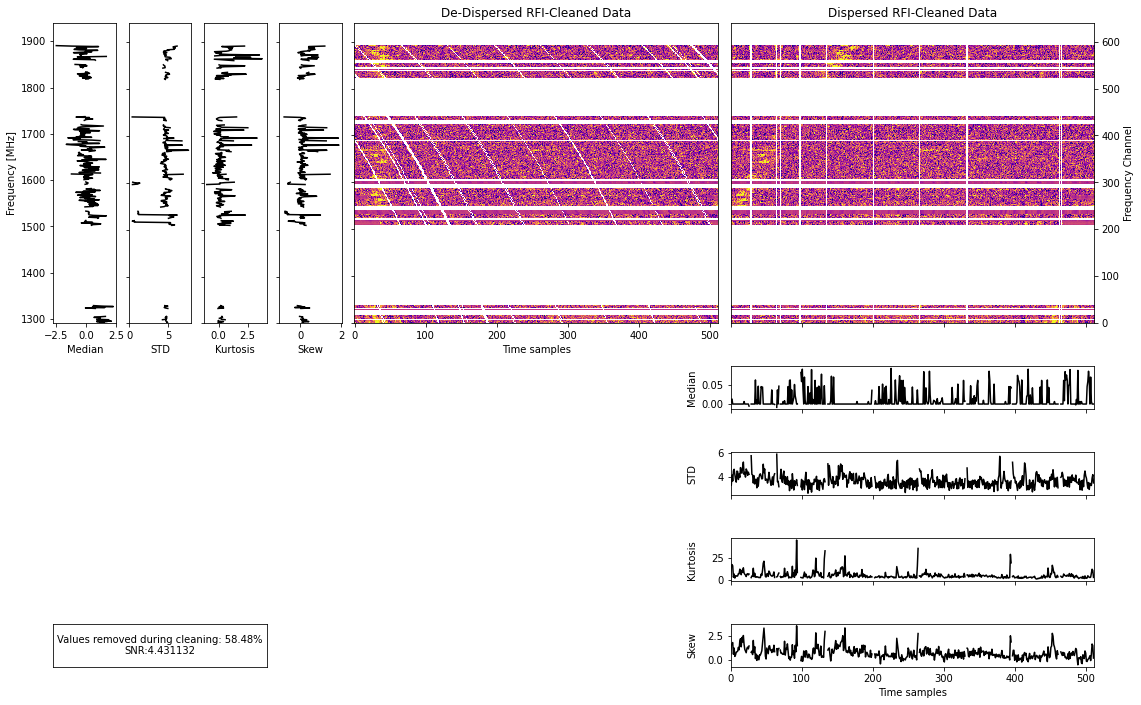

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


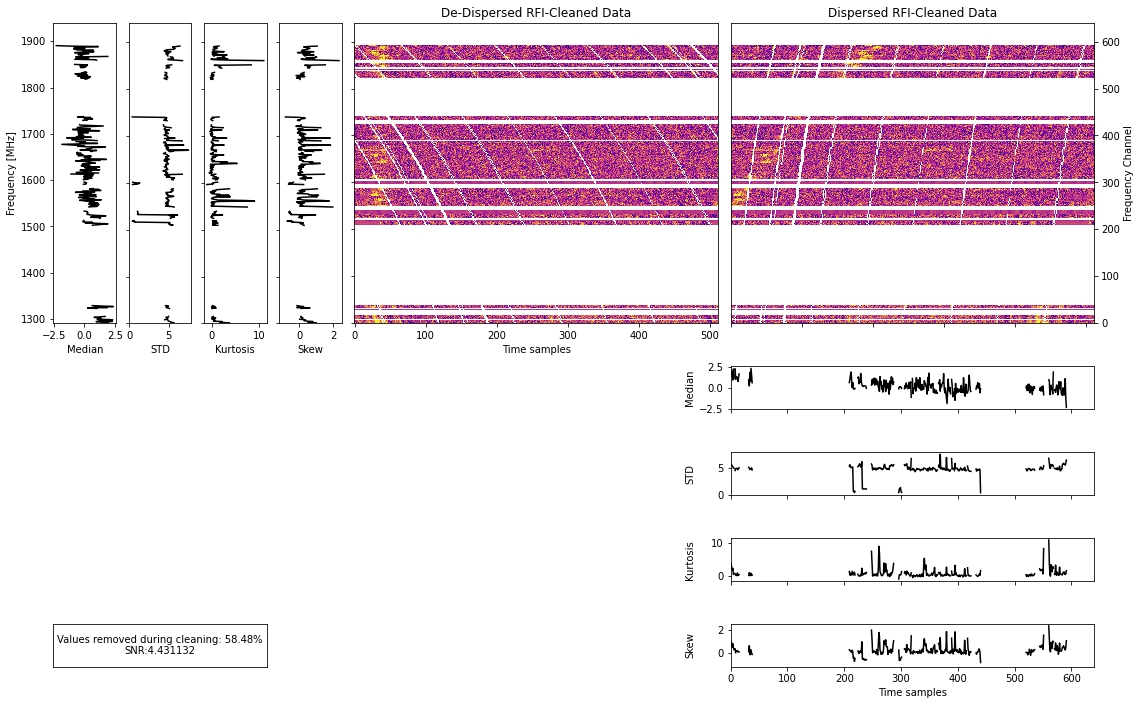

In [33]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280414829.ar'
file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/filtool_cleaned_files/pulse_3280414829.ar'
#file_path  = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
#clean_and_plot(file_path, threshold_disp = 2.0, threshold_dedisp = 50, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_initial_stats = False, plot_compact_stats = True)
result_array = clean_and_plot(file_path, threshold_dedisp = 4, threshold_disp = 100, on_pulse_start = 10, on_pulse_end = 50, \
               plot_compact_initial_stats = False, plot_compact_stats = True, iterate = True)


median_arr, std_arr, kurtosis_arr, skew_arr = Calculate_4Stats(result_array)
file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
time_res = 512 #Number of bins
result_array_disp = disperse(result_array, dm, center_freq, freq_mhz, time_res)
nan_percent = nan_percentage(result_array)
snr = calculate_snr(result_array, 10, 50)
median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp = Calculate_4Stats(result_array_disp)
plot_statistics(result_array, freq_mhz, 640, median_arr, std_arr, kurtosis_arr, skew_arr, \
                    median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp, nan_percent, snr,\
                        plot_title_dedisp = 'De-Dispersed RFI-Cleaned Data', plot_title_disp = 'Dispersed RFI-Cleaned Data')


#iterative_clean_and_plot(file_path, result_array, threshold_dedisp = 500, threshold_disp = 500, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_initial_stats = False, plot_compact_stats = True, iterate = True)

Test below shows us that there are not two different "statistical populations" between RFI data and non-RFI data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


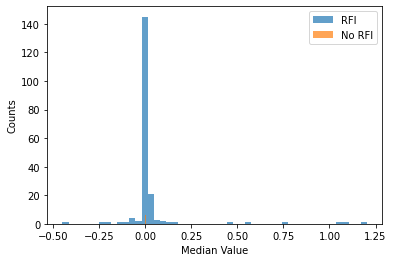

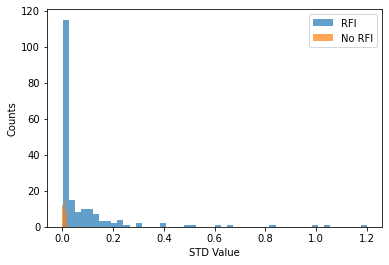

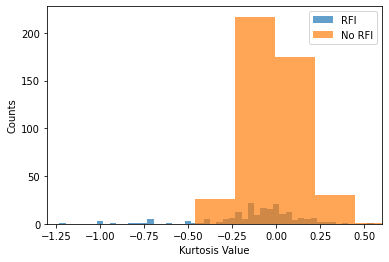

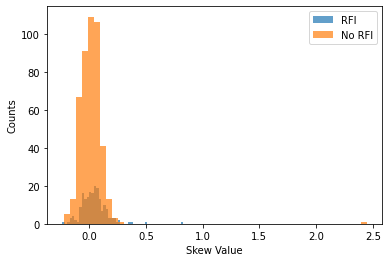

In [34]:
file_path = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
file_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = True)
threshold_dedisp = 0.04
threshold_disp = 500
on_pulse_start = 110
on_pulse_end = 150
plot_compact_initial_stats = False
plot_compact_stats = False

median_arr, std_arr, kurtosis_arr, skew_arr = Calculate_4Stats(file_data)
#Convert the lists to numpy arrays
median_arr = np.array(median_arr)
std_arr = np.array(std_arr)

chns_with_RFI = [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 232, 233, 234, 235, 236, 263, 264, 265, 266, 267, 268, 269, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 621 ,622 ,623 ,624, 625, 626, 627, 628, 292, 293, 294, 295, 296, 297, 298, 299, 300, 139, 140, 141, 278, 279, 280, 281, 282, 370]
median_RFI = median_arr[chns_with_RFI]
std_RFI = std_arr[chns_with_RFI]
kurtosis_RFI = kurtosis_arr[chns_with_RFI]
skew_RFI = skew_arr[chns_with_RFI]

# Create a boolean mask with True for indices to exclude
mask_median = np.full_like(median_arr, True, dtype=bool)
mask_median[chns_with_RFI] = False
mask_std = np.full_like(std_arr, True, dtype=bool)
mask_std[chns_with_RFI] = False
mask_kurtosis = np.full_like(kurtosis_arr, True, dtype=bool)
mask_kurtosis[chns_with_RFI] = False
mask_skew = np.full_like(skew_arr, True, dtype=bool)
mask_skew[chns_with_RFI] = False

# Use the mask to select all values except those at specified indices
median_no_RFI = median_arr[mask_median]
std_no_RFI = std_arr[mask_std]
kurtosis_no_RFI = kurtosis_arr[mask_kurtosis]
skew_no_RFI = skew_arr[mask_skew]

plt.hist(median_RFI, bins = 50, label = 'RFI', alpha=0.7)
plt.hist(median_no_RFI, bins = 50, label = 'No RFI', alpha=0.7)
plt.ylabel('Counts')
plt.xlabel('Median Value')
plt.legend()
plt.show()
plt.close()

plt.hist(std_RFI, bins = 50, label = 'RFI', alpha=0.7)
plt.hist(std_no_RFI, bins = 50, label = 'No RFI', alpha=0.7)
plt.ylabel('Counts')
plt.xlabel('STD Value')
plt.legend()
plt.show()
plt.close()

plt.hist(kurtosis_RFI, bins = 50, label = 'RFI', alpha=0.7)
plt.hist(kurtosis_no_RFI, bins = 50, label = 'No RFI', alpha=0.7)
plt.ylabel('Counts')
plt.xlabel('Kurtosis Value')
plt.xlim(-1.3, 0.6)
plt.legend()
plt.show()
plt.close()

plt.hist(skew_RFI, bins = 50, label = 'RFI', alpha=0.7)
plt.hist(skew_no_RFI, bins = 50, label = 'No RFI', alpha=0.7)
plt.ylabel('Counts')
plt.xlabel('Skew Value')
plt.legend()
plt.show()
plt.close()

Now we will plot all the frequency intensities to see if they show differences.

file_path = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
file_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = True)
threshold_dedisp = 0.04
threshold_disp = 500
on_pulse_start = 110
on_pulse_end = 150
plot_compact_initial_stats = False
plot_compact_stats = False

#Create cleaned data
chns_with_RFI = [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 232, 233, 234, 235, 236, 263, 264, 265, 266, 267, 268, 269, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 621 ,622 ,623 ,624, 625, 626, 627, 628, 292, 293, 294, 295, 296, 297, 298, 299, 300, 139, 140, 141, 278, 279, 280, 281, 282, 370]

# Create a boolean mask with True for indices to exclude
mask = np.full_like(file_data, True, dtype=bool)
mask[chns_with_RFI] = False

# Use the mask to select all values except those at specified indices
data_no_RFI = file_data[mask]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(8, 20))

# Plot data in the first subplot
for i, intensity_values in enumerate(file_data):
    # Use the index 'i' as the y-value
    axs[0].plot(intensity_values + i, label=f'Line {i+1}')

# Add labels, title, and legend to the first subplot
axs[0].set_xlabel('Pulse Phase')
axs[0].set_ylabel('Intensity Profile')
axs[0].set_title('RFI (Subplot 1)')
axs[0].legend()

# Plot data in the second subplot
for i, intensity_values in enumerate(data_no_RFI):
    axs[1].plot(intensity_values + i, label=f'Line {i+1}')

# Add labels, title, and legend to the second subplot
axs[1].set_xlabel('Pulse Phase')
axs[1].set_ylabel('Intensity Profile')
axs[1].set_title('No RFI (Subplot 2)')
axs[1].legend()

The test below is to test if the de-dispersion is working.

In [35]:
#file_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
#file_data = np.flip(file_data, axis = 0)
#plt.imshow(file_data, aspect='auto', cmap=plt.get_cmap('plasma'), vmin = np.nanpercentile(file_data, 1), vmax = np.nanpercentile(file_data, 99), interpolation='none')

#file_path = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
#threshold_dedisp = 0.04
#threshold_disp = 500
#on_pulse_start = 110
#on_pulse_end = 150
#plot_compact_initial_stats = False
#plot_compact_stats = True

#Dispersed Data
#file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
#bad_chn_list = [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 232, 233, 234, 235, 236, 263, 264, 265, 266, 267, 268, 269, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 621 ,622 ,623 ,624, 625, 626, 627, 628, 292, 293, 294, 295, 296, 297, 298, 299, 300, 139, 140, 141, 278, 279, 280, 281, 282, 370]
#cleaned_data = Zap_Bad_Freqs(file_data_disp, bad_chn_list, read_file = False)

#fig = plt.figure()
#fig.set_figheight(8)
#fig.set_figwidth(10)
#plt.imshow(cleaned_data, aspect='auto', cmap=plt.get_cmap('plasma'), vmin = np.nanpercentile(cleaned_data, 1), vmax = np.nanpercentile(cleaned_data, 99), interpolation='none', origin='lower')

#De-dispersed Data
#file_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = True)
#bad_chn_list = [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 232, 233, 234, 235, 236, 263, 264, 265, 266, 267, 268, 269, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 621 ,622 ,623 ,624, 625, 626, 627, 628, 292, 293, 294, 295, 296, 297, 298, 299, 300, 139, 140, 141, 278, 279, 280, 281, 282, 370]
#cleaned_data = Zap_Bad_Freqs(file_data, bad_chn_list, read_file = False)

#Testing
#start_row = 350
#end_row = 450
#start_col = 200
#end_col = 210
# Replace the values within the specified range with 10000
#for i in range(start_row, end_row + 1):
#    for j in range(start_col, end_col + 1):
#        cleaned_data[i][j] = 10000
        
#cleaned_data_disp = disperse(cleaned_data, dm, center_freq, freq_mhz, time_res)
#cleaned_data_disp_flip = np.flip(cleaned_data_disp, axis = 1)
#fig = plt.figure()
#fig.set_figheight(8)
#fig.set_figwidth(10)
#plt.imshow(cleaned_data_disp, aspect='auto', cmap=plt.get_cmap('plasma'), vmin = np.nanpercentile(cleaned_data, 1), vmax = np.nanpercentile(cleaned_data, 99), interpolation='none', origin='lower')


In [36]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280415144.ar'
#clean_and_plot(file_path, threshold_disp = 1, threshold_dedisp = 2.5, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [37]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280415152.ar'
#clean_and_plot(file_path, threshold_disp = 2, threshold_dedisp = 2, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [38]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280415548.ar'
#clean_and_plot(file_path, threshold_disp = 1, threshold_dedisp = 3, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [39]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280415947.ar'
#clean_and_plot(file_path, threshold_disp = 1, threshold_dedisp = 3, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [40]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280416357.ar'
#clean_and_plot(file_path, threshold_disp = 1, threshold_dedisp = 3, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [41]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280416743.ar'
#clean_and_plot(file_path, threshold_disp = 1.5, threshold_dedisp = 2, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True)

In [42]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280416134.ar'
#clean_and_plot(file_path, threshold_disp = 2, threshold_dedisp = 2, on_pulse_start = 10, on_pulse_end = 50, \
#               plot_compact_stats = True, show_mean_intensity = True)

# 